<a href="https://colab.research.google.com/github/ilhamydn17/cara-wicara-ml-lab/blob/master/Model_ML_CaraWicara_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Library for Detecting Image

In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

from scipy import ndimage, misc
import skimage

### Import Library for Preprocessing Image

In [ ]:
import cv2 as cv
from PIL import Image, ImageOps, ImageEnhance
import random

### Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzipping Drive Datasets (Skip able)


In [ ]:
from zipfile import ZipFile
import os

# Dalam ini hal ini kami menggunakan data yg diupload ke google drive pribadi sehingga anda dapat mendownload datanya pada foler Data-Kaggle-Augmentation
# Ganti dengan path file zip Anda
zip_path = "/content/drive/MyDrive/Nostalgia - KMIPN VII/Down-Syndrome-Face.zip"

# Ganti dengan path direktori tempat Anda ingin mengekstrak file
extract_path = "/content/drive/MyDrive/Nostalgia - KMIPN VII"

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("File berhasil di-unzip di direktori:", extract_path)

File berhasil di-unzip di direktori: /content/drive/MyDrive/Nostalgia - KMIPN VII


In [ ]:
import os

extract_path = "/content/drive/MyDrive/Nostalgia-KMIPNVI"
filelist = []

# List directories and files in the extracted path
for dirname, _, filenames in os.walk(extract_path):
  print(f"Found directory: {dirname}")
  for filename in filenames:
    filelist.append(os.path.join(dirname, filename))
    print(f"Found file: {filename}")

print(f"Total files found: {len(filelist)}")

Total files found: 0


In [ ]:
labels_needed = ['Heran', 'Sedih', 'Senang', 'Tenang', 'Tertawa']

In [ ]:
Filepaths   = []
labels = []

for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    if label in labels_needed:

        Filepaths.append(image_file)
        labels.append(label)

x = np.array(Filepaths)
y = np.array(labels)

# Buat dataframe dari path gambar dan labels
file_path = pd.Series(Filepaths, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)

# Periksa distribusi kelas
print(data['Labels'].value_counts())

Series([], Name: count, dtype: int64)


In [ ]:
set(labels_needed)

{'Heran', 'Sedih', 'Senang', 'Tenang', 'Tertawa'}

In [ ]:
import glob
path = '/content/drive/MyDrive/Nostalgia-KMIPNVI/Down-Syndrome-Face'
path_imgs = list(glob.glob(path+'/**/*.jpg') + glob.glob(path+'/**/*.png') + glob.glob(path+'/**/*.jpeg'))


In [ ]:
len(path_imgs)

1493

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/drive/MyDrive/Nostalgia-KMIPNVI/Down-...,Tenang
1,/content/drive/MyDrive/Nostalgia-KMIPNVI/Down-...,Tenang
2,/content/drive/MyDrive/Nostalgia-KMIPNVI/Down-...,Senang
3,/content/drive/MyDrive/Nostalgia-KMIPNVI/Down-...,Tenang
4,/content/drive/MyDrive/Nostalgia-KMIPNVI/Down-...,Senang


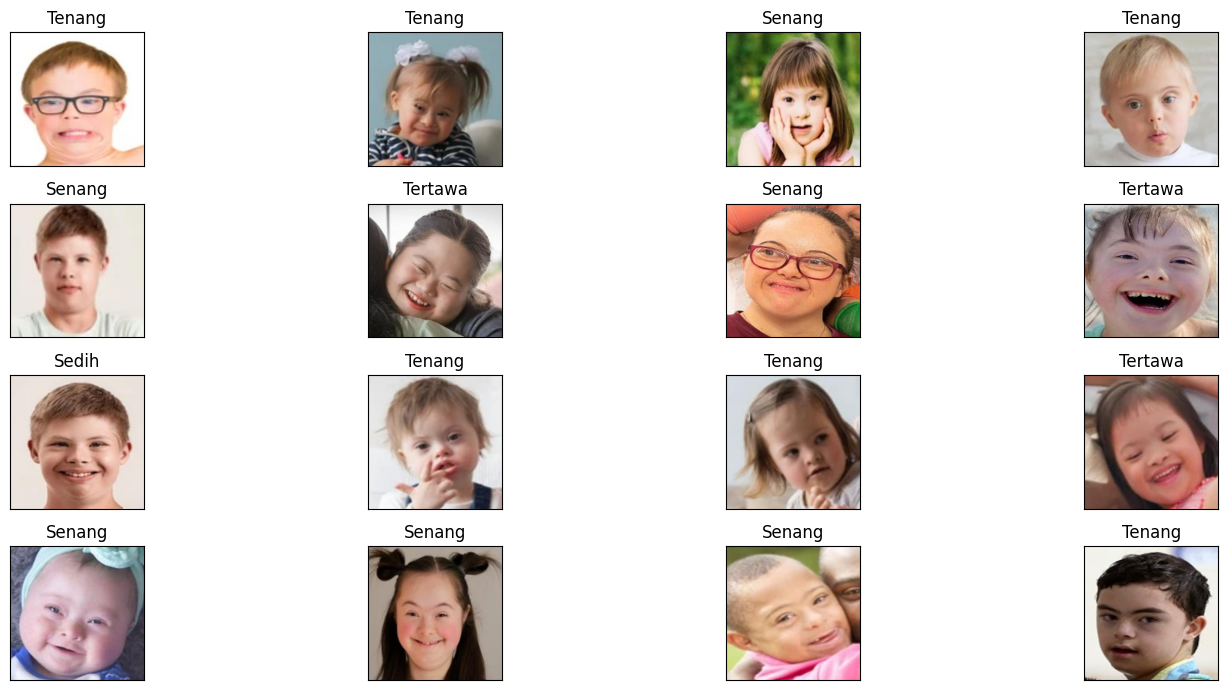

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

### Preprocessing Image

In [ ]:
def preprocess_image(image_path):
    # Load image
    image = cv.imread(image_path)

    # Resize image to (224, 224)
    image_resized = cv.resize(image, (224, 224))

    # Convert image to grayscale
    image_gray = cv.cvtColor(image_resized, cv.COLOR_BGR2GRAY)

    # Normalize image
    image_normalized = image_gray / 255.0

    # Apply Gaussian Blur
    image_blurred = cv.GaussianBlur(image_normalized, (5, 5), 0)

    return image_blurred

In [ ]:
def augment_image(image):
    pil_image = Image.fromarray((image * 255).astype(np.uint8))

    # Flip image horizontally
    image_flipped = ImageOps.mirror(pil_image)

    # Enhance contrast
    enhancer = ImageEnhance.Contrast(image_flipped)
    image_contrast = enhancer.enhance(1.5)

    # Rotate image
    image_rotated = image_contrast.rotate(15)

    return np.array(image_rotated) / 255.0

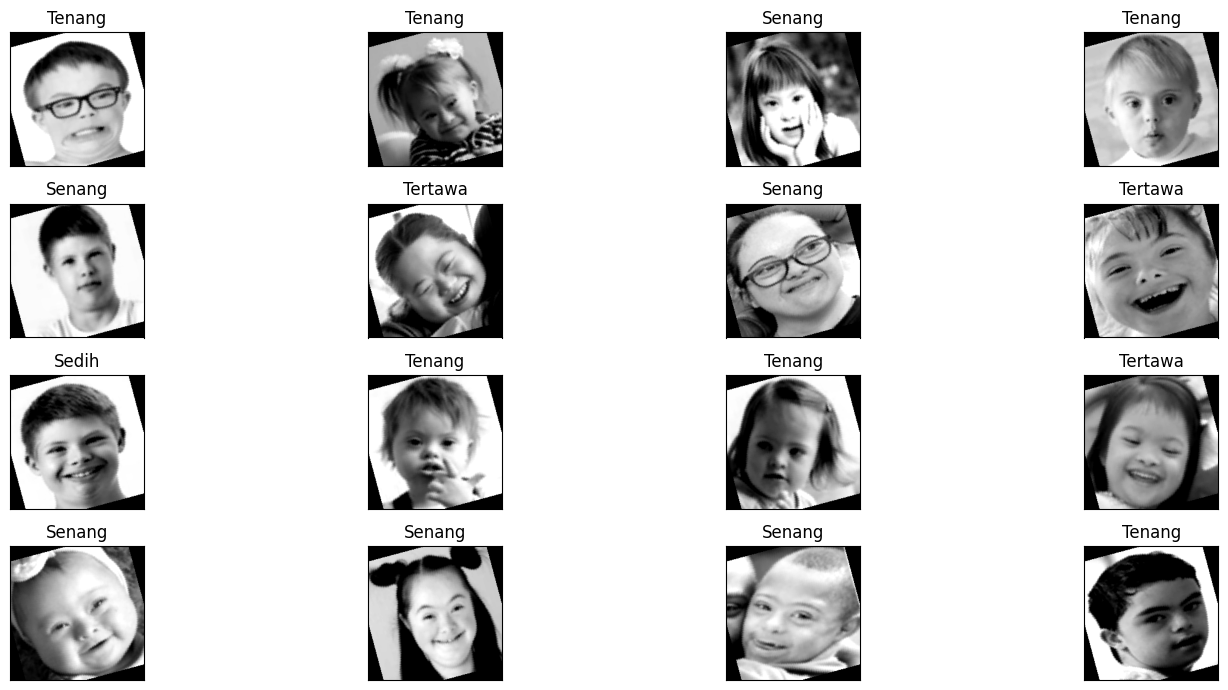

In [ ]:
# implement preprocessing
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    preprocessed_image = preprocess_image(data.File_Path[i])
    augmented_image = augment_image(preprocessed_image)
    ax.imshow(augmented_image, cmap='gray')
    ax.set_title(data.Labels[i])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(data, test_size=0.2, random_state=2, stratify=data['Labels'])

# Periksa distribusi kelas di kedua subset data
print("Training set:")
print(train_df['Labels'].value_counts())
print("\nValidation set:")
print(valid_df['Labels'].value_counts())

Training set:
Labels
Senang     527
Tertawa    216
Tenang     194
Sedih      138
Heran      119
Name: count, dtype: int64

Validation set:
Labels
Senang     132
Tertawa     54
Tenang      48
Sedih       35
Heran       30
Name: count, dtype: int64


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def gen(pre, train, valid):
    train_datagen = ImageDataGenerator(
        preprocessing_function=pre,
        rotation_range=40,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest"
    )
    valid_datagen = ImageDataGenerator(
        preprocessing_function=pre
    )

    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0
    )
    valid_gen = valid_datagen.flow_from_dataframe(
        dataframe=valid,
        x_col='File_Path',
        y_col='Labels',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0
    )

    return train_gen, valid_gen


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

def func(name_model):
    pre_model = name_model(input_shape=(224, 224, 3),
                           include_top=False,
                           weights='imagenet',
                           pooling='avg')

    # tuning dari 20 layer terakhir
    for layer in pre_model.layers[-20:]:
        layer.trainable = True

    inputs = pre_model.input
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(pre_model.output)
    x = BatchNormalization()(x) # -> new
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x) # -> new
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    def lr_schedule(epoch):
        lr = 1e-3
        if epoch > 10:
            lr *= 0.1
        return lr

    lr_scheduler = LearningRateScheduler(lr_schedule)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])
    my_callbacks = [lr_scheduler, early_stopping, reduce_lr]

    return model, my_callbacks

In [ ]:
def plot(history,valid_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])

    # Predict Data Test
    pred = model.predict(valid_gen)
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    # Classification report
    cm=confusion_matrix(valid_df.Labels,pred)
    clr = classification_report(valid_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(valid_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {valid_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()

    return history

In [ ]:
def result_test(valid,model_use):
    results = model_use.evaluate(valid, verbose=0)

    print("Validation Loss: {:.5f}".format(results[0]))
    print("Validation Accuracy: {:.2f}%".format(results[1] * 100))

    return results

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

EfficientNetB0_pre=preprocess_input
train_gen_EfficientNetB0, valid_gen_EfficientNetB0 = gen(EfficientNetB0_pre, train_df, valid_df)
EfficientNetB0_model, callback=func(EfficientNetB0)
history = EfficientNetB0_model.fit(
    train_gen_EfficientNetB0,
    validation_data=valid_gen_EfficientNetB0,
    epochs=3,
    callbacks=callback,
    verbose=1)

Found 1194 validated image filenames belonging to 5 classes.
Found 299 validated image filenames belonging to 5 classes.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/3
33/38 [=========================>....] - ETA: 43s - loss: 14.8243 - accuracy: 0.2157

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


38/38 [==============================] - 449s 11s/step - loss: 14.7675 - accuracy: 0.2144 - val_loss: 13.5673 - val_accuracy: 0.3311 - lr: 0.0010
Epoch 2/3
38/38 [==============================] - 355s 9s/step - loss: 13.9371 - accuracy: 0.2638 - val_loss: 12.8773 - val_accuracy: 0.4114 - lr: 0.0010
Epoch 3/3
38/38 [==============================] - 348s 9s/step - loss: 12.9804 - accuracy: 0.3149 - val_loss: 13.1197 - val_accuracy: 0.2910 - lr: 0.0010


### Saving Model (Export)

In [ ]:
# save/export model to .h5 file
model_name = 'EfficientNetB0_model.h5'
saved_model = EfficientNetB0_model.save(model_name)

print(f"Model exported to {model_name}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model exported to EfficientNetB0_model.h5


10/10 [==============================] - 20s 2s/step
              precision    recall  f1-score   support

       Heran       0.17      0.70      0.27        30
       Sedih       0.12      0.03      0.05        35
      Senang       0.49      0.33      0.40       132
      Tenang       0.20      0.23      0.22        48
     Tertawa       0.43      0.19      0.26        54

    accuracy                           0.29       299
   macro avg       0.29      0.30      0.24       299
weighted avg       0.36      0.29      0.29       299



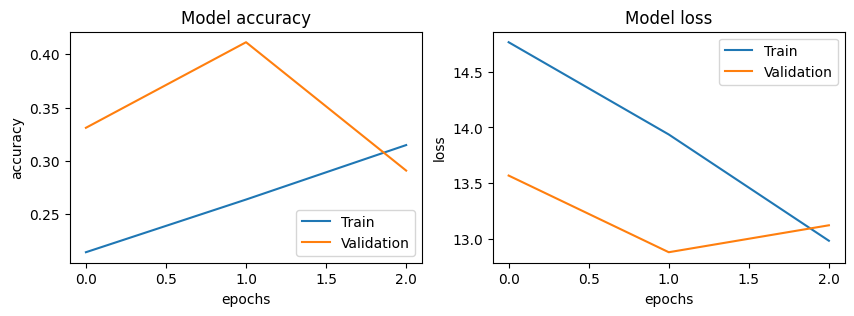

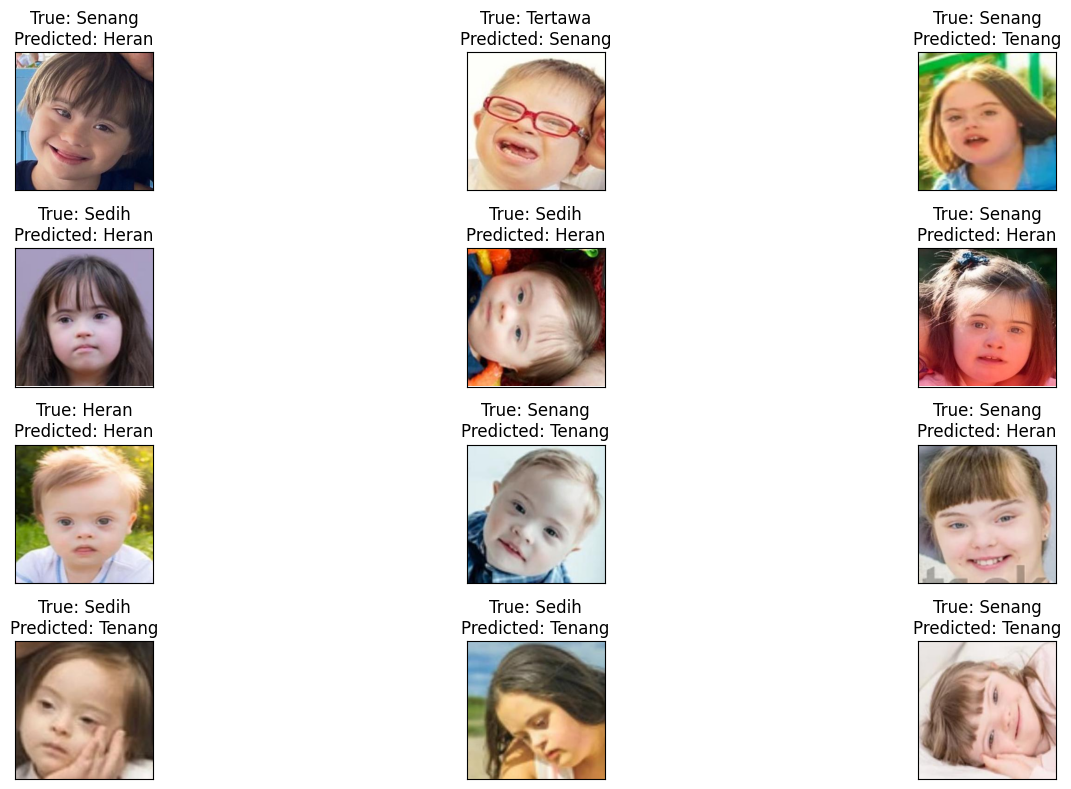

Validation Loss: 13.11973
Validation Accuracy: 29.10%


In [ ]:
history_EfficientNetB0 = plot(history, valid_gen_EfficientNetB0, train_gen_EfficientNetB0, EfficientNetB0_model)

result_EfficientNetB0 = result_test(valid_gen_EfficientNetB0, EfficientNetB0_model)

1/1 [==============================] - 2s 2s/step


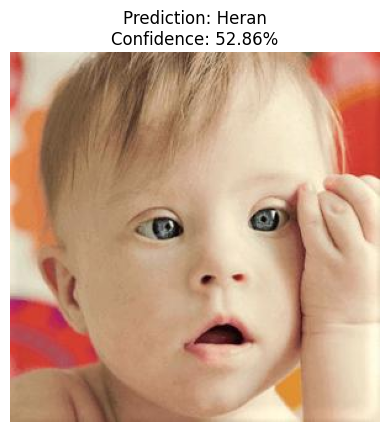

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

# Function to preprocess input image
def preprocess_input_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0);
    img_array = preprocess_input(img_array)  # used preprocess_input during training
    return img_array

# Function to display results
def display_results(img_path, predictions, labels):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis('off')

    predicted_label = labels[np.argmax(predictions)]
    confidence = predictions[0][np.argmax(predictions)] * 100

    plt.title(f'Prediction: {predicted_label}\nConfidence: {confidence:.2f}%')
    plt.show()

#  list of class labels
class_labels = ['Heran', 'Sedih', 'Senang', 'Tenang', 'Tertawa']

# Image path for testing (replace with the actual path to the uploaded image)
image_path_to_predict = "heran.jpg"

# Run the prediction
predictions = EfficientNetB0_model.predict(preprocess_input_image(image_path_to_predict))

# Display the results
display_results(image_path_to_predict, predictions, class_labels)

### Prediction Using Exported Model

1/1 [==============================] - 2s 2s/step


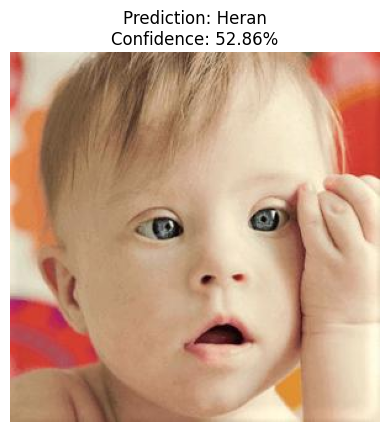

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# Function to preprocess input image
def preprocess_input_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0);
    img_array = preprocess_input(img_array)  # used preprocess_input during training
    return img_array

# Function to display results
def display_results(img_path, predictions, labels):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis('off')

    predicted_label = labels[np.argmax(predictions)]
    confidence = predictions[0][np.argmax(predictions)] * 100

    plt.title(f'Prediction: {predicted_label}\nConfidence: {confidence:.2f}%')
    plt.show()

#  list of class labels
class_labels = ['Heran', 'Sedih', 'Senang', 'Tenang', 'Tertawa']

# Image path for testing (replace with the actual path to the uploaded image)
image_path_to_predict = "heran.jpg"

# Load the model from the .h5 file
model_path = "EfficientNetB0_model.h5"  # Replace with your actual model path
model = load_model(model_path)
prediction = model.predict(preprocess_input_image(image_path_to_predict))

# Display the results
display_results(image_path_to_predict, prediction, class_labels)

In [ ]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# Function to preprocess input image
def preprocess_input_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # used preprocess_input during training
    return img_array

# Function to display results
def display_results(img_path, predictions, labels, model_accuracy=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis('off')

    predicted_label = labels[np.argmax(predictions)]
    confidence = predictions[0][np.argmax(predictions)] * 100

    title = f'Prediction: {predicted_label}\nConfidence: {confidence:.2f}%'
    if model_accuracy is not None:
        title += f'\nModel Accuracy: {model_accuracy:.2f}%'

    plt.title(title)
    plt.show()

# List of class labels
class_labels = ['Heran', 'Sedih', 'Senang', 'Tenang', 'Tertawa']

# Image path for testing (replace with the actual path to the uploaded image)
image_path_to_predict = "heran.jpg"

# Load the model from the .h5 file
model_path = "testing.h5"  # Replace with your actual model path
model = load_model(model_path)

# Optionally, calculate the model accuracy on a validation set
# Assuming `valid_gen` is your validation data generator
# model_accuracy = model.evaluate(valid_gen, verbose=0)[1] * 100

# Alternatively, if you don't have a validation generator, set model_accuracy to None
model_accuracy = None

# Run the prediction
prediction = model.predict(preprocess_input_image(image_path_to_predict))

# Display the results
display_results(image_path_to_predict, prediction, class_labels, model_accuracy=True)


OSError: Unable to open file (truncated file: eof = 15728640, sblock->base_addr = 0, stored_eof = 59317808)

In [ ]:
def preprocess_image(image_path):
    # Load image
    image = cv.imread(image_path)

    # Resize image to (224, 224)
    image_resized = cv.resize(image, (224, 224))

    # Convert image to grayscale
    image_gray = cv.cvtColor(image_resized, cv.COLOR_BGR2GRAY)

    # Normalize image
    image_normalized = image_gray / 255.0

    # Apply Gaussian Blur
    image_blurred = cv.GaussianBlur(image_normalized, (5, 5), 0)

    return image_blurred


